In [2]:
from dyadic_fem import *
%matplotlib notebook

## First we check our FEM solution against a known analytic solution
Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM, where $a(x)=1$ is constant, with  homogeneous Dirichlet bdry conditions and $f(x) = 1$. This is the Poisson equation and has a known analytic solution, which we check our solution against. 

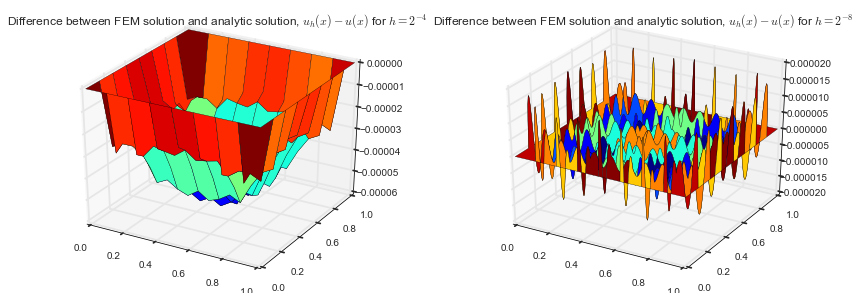

In [21]:
constant_field = ConstantField(c=1.0)

fem_coarse = DyadicFEMSolver(div=4, rand_field=constant_field, f=1.0)
fem_fine = DyadicFEMSolver(div=8, rand_field=constant_field, f=1.0)

# We make the appropriate grid for both the fine and the coarse FEM solution
x = np.linspace(0.0, 1.0, fem_coarse.n_side + 2, endpoint = True) 
xs_coarse, ys_coarse = np.meshgrid(x, x)
x = np.linspace(0.0, 1.0, fem_fine.n_side + 2, endpoint = True) 
xs_fine, ys_fine = np.meshgrid(x, x)

def analytic_soln(x,y,N=10,M=10):
    # This is the standard series solution for the Poisson problem on the unit square 
    # with homogeneous dirichelet boundaries and uniform force f=1
    soln = np.zeros(x.shape)
    for i in range(N):
        for j in range(M):
            n = 2*i+1
            m = 2*j+1
            soln = soln + (4.0 / (math.pi*math.pi*math.pi*math.pi)) * (1.0/(n*m*(n*n + m*m))) * \
                    np.sin(n*math.pi*x) * np.sin(m*math.pi*y)   
    return soln

# Solve both the FEM problems
fem_coarse.solve()
fem_fine.solve()

%matplotlib inline
# Now just plot the difference between the analytic solution and the FEM solution
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_axis_bgcolor('white')
wframe_diff = ax.plot_surface(xs_coarse, ys_coarse, fem_coarse.u - analytic_soln(xs_coarse, ys_coarse), 
                                  cstride=2**(fem_coarse.div - 3), rstride=2**(fem_coarse.div-3), cmap=cm.jet)
ax.set_title('Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-4}$')

fig2 = plt.figure(1,2,2)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_axis_bgcolor('white')
wframe_diff_2 = ax2.plot_surface(xs_fine, ys_fine, fem_fine.u - analytic_soln(xs_fine, ys_fine), 
                                  cstride=2**(fem_fine.div - 3), rstride=2**(fem_fine.div-3), cmap=cm.jet)
ax2.set_title('Difference between FEM solution and analytic solution, $u_h(x) - u(x)$ for $h=2^{-8}$')

plt.show()
%matplotlib notebook

We see that the FEM solution on the $2^8$ subdivided square (RHS above) has converged closer to the analytic solution than the $2^4$ subdivided square (LHS above).

# We trust our FEM solution is correct, now we try arbitrary dyadic fields

Here we solve the problem $$-\nabla \cdot (a(x) \nabla u(x)) = f(x)$$ using FEM,where $a(x)$ is a randomly generated piecewise constant function on the dyadic subdivision of the unit square. The field is given by 
$$ a(x) = \bar{a} + c \sum_i y_i \mathbb{1}_{s_i}(x) $$
where $\bar{a}$ and $c$ are constants (given below), $y_i$ is a uniform RV from $[-1,1]$, and $\mathbb{1}_{s_i}$ is the indicator function on the $i$-th dyadic square $s_i$.

<IPython.core.display.Javascript object>


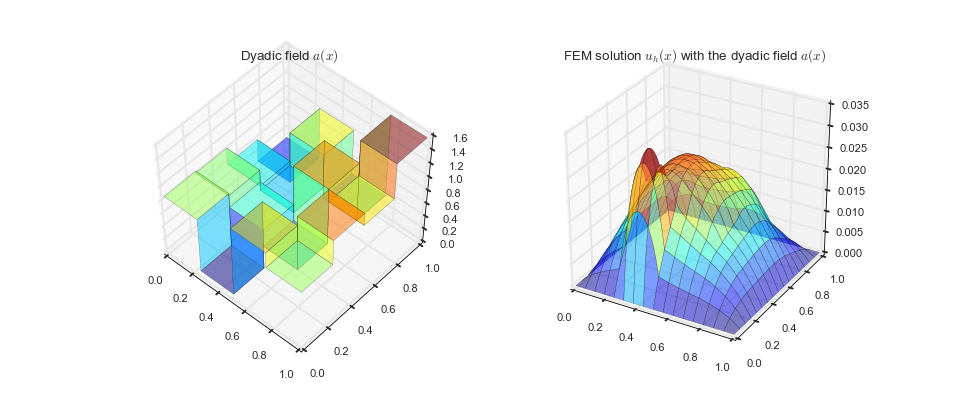

In [2]:
field = DyadicField(div=2, a_bar=1.0, c=0.99, seed=2)
fem = DyadicFEMSolver(div=6, rand_field=field, f=1.0)

fem.solve()

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')

# We do some tricks here (i.e. using np.repeat) to plot the piecewise constant nature of the random field...
x = np.linspace(0.0, 1.0, field.n_side+1, endpoint = True).repeat(2)[1:-1]
xs, ys = np.meshgrid(x, x)
wframe = ax.plot_surface(xs, ys, field.field.repeat(2, axis=0).repeat(2, axis=1), cstride=1, rstride=1,
                         cmap=cm.jet, alpha=0.5)
ax.set_title('Dyadic field $a(x)$')
ax.set_axis_bgcolor('white')
ax = fig.add_subplot(1, 2, 2, projection='3d')


x = np.linspace(0.0, 1.0, fem.n_side + 2, endpoint = True)
xs, ys = np.meshgrid(x, x)
div_frame = 4
wframe = ax.plot_surface(xs, ys, fem.u, cstride=2**(fem.div - div_frame), rstride=2**(fem.div-div_frame),
                         cmap=cm.jet, alpha=0.5)
ax.set_axis_bgcolor('white')
ax.set_title('FEM solution $u_h(x)$ with the dyadic field $a(x)$')

#field.plot()
#fem.plot()

plt.show()

## Test L2 and H1 inner product routines in PWLinearFunction
We test the $L^2$ and $H^1_0$ inner products for functions in $U_h$ (our dyadic triangulation subspace), for a test function $u(x,y) = \sin(\pi x) \sin(\pi y)$

In [2]:
# Probably a good idea just to test our grid interpolation and L2 and H1
# dot product routines...

# Lets try an analytic function with a known integral, 
# say sin(pi*x)* sin(pi*y), for which the analytic solution is 1/4

print('Testing convergence of L2 product to analytic soln of 0.25 \n \
and H1 dot product to pi * pi / 2, for increasing dyadic subdiv')
for div in range(2,12,2):
    
    xs = np.linspace(0.0, 1.0, 2**div+1, endpoint=True)
    x,y = np.meshgrid(xs, xs)
    
    u = PWLinearFunction(np.sin(math.pi*x)*np.sin(math.pi*y), div)
    
    # These values should both converge to 1/4, though the element wise sum should 
    # converge much slower...
    print('Dyadic division level', div)
    print('L2:', u.L2_dot(u), 'Target: 0.25, H1:', u.H1_dot(u), 'Target:', math.pi * math.pi / 2.0)
    # NB this should be close to L2: (u.values * u.values).sum() / ((2**div+1) * (2**div+1)),

Testing convergence of L2 product to analytic soln of 0.25 
 and H1 dot product to pi * pi / 2, for increasing dyadic subdiv
Dyadic division level 2
L2: 0.204758898432 Target: 0.25, H1: 4.68629150102 Target: 4.934802200544679
Dyadic division level 4
L2: 0.246812930294 Target: 0.25, H1: 4.91896821677 Target: 4.934802200544679
Dyadic division level 6
L2: 0.249799303156 Target: 0.25, H1: 4.93381138361 Target: 4.934802200544679
Dyadic division level 8
L2: 0.249987450543 Target: 0.25, H1: 4.93474026982 Target: 4.934802200544679
Dyadic division level 10
L2: 0.249999215636 Target: 0.25, H1: 4.93479832986 Target: 4.934802200544679


## Now we look at coarse grid approximations, i.e. $V_n$ is the space of $n$ coarse grid hat functions

In [ ]:
    
# Look at coarse grid divergence / approximation

# Generate V_n space from a few solutions and see how they correspond / approximate a solution by projection

#